In [1]:
import sys, os
import re

import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
from scipy import stats
import datetime

import pyodbc

sys.path.insert(0, os.path.realpath('..'))
import Utilities_config

#---------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
#---------------------------------------------------------------------
sys.path.insert(0, Utilities_config.get_utilities_dir())
import Utilities
import Utilities_df
import Utilities_dt
import Plot_Box_sns
import GrubbsTest

In [2]:
conn = Utilities.get_athena_prod_aws_connection()

In [3]:
# sql = 'Show partitions default.meter_premise'

# sql = ("Select * from usage_nonvee.reading_ivl_nonvee \
#        where aep_opco = 'oh' \
#        and aep_usage_dt = '2021-10-12' \
#        and aep_derived_uom = 'KWH' \
#        and serialnumber = '436403564'")


cols_of_interest = ['serialnumber', 'starttimeperiod', 'endtimeperiod', 'aep_endtime_utc', 
                    'timezoneoffset', 'aep_srvc_qlty_idntfr', 'value']
sql = ("Select {} \
       from usage_nonvee.reading_ivl_nonvee \
       where aep_opco = 'oh' \
       and aep_usage_dt = '2021-10-12' \
       and aep_derived_uom = 'KWH' \
       and serialnumber = '436403564'").format(','.join(cols_of_interest))


In [4]:
df_full = pd.read_sql(sql, conn)
print(f'df_full.shape = {df_full.shape}')

df_full.shape = (192, 7)


In [5]:
#df_full.to_csv(os.path.join(Utilities.get_local_data_dir(), r'usage_nonvee_singleSN.csv'), index=False)

In [6]:
df_full.columns

Index(['reading_ivl_nonvee.serialnumber', 'reading_ivl_nonvee.starttimeperiod',
       'reading_ivl_nonvee.endtimeperiod',
       'reading_ivl_nonvee.aep_endtime_utc',
       'reading_ivl_nonvee.timezoneoffset',
       'reading_ivl_nonvee.aep_srvc_qlty_idntfr', 'reading_ivl_nonvee.value'],
      dtype='object')

In [7]:
df_full['reading_ivl_nonvee.serialnumber'].unique()

array(['436403564'], dtype=object)

In [8]:
common_col_name = 'reading_ivl_nonvee.'
cols_rename_dict = {x:x[len(common_col_name):] if x.find(common_col_name)>-1 else x 
                    for x in df_full.columns}
df_full = df_full.rename(columns=cols_rename_dict)

In [9]:
df_full.columns

Index(['serialnumber', 'starttimeperiod', 'endtimeperiod', 'aep_endtime_utc',
       'timezoneoffset', 'aep_srvc_qlty_idntfr', 'value'],
      dtype='object')

In [10]:
df_full.head()

,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,aep_srvc_qlty_idntfr,value
0,436403564,2021-10-12T17:45:00-04:00,2021-10-12T18:00:00-04:00,1634076000,-04:00,DELIVERED,4.014
1,436403564,2021-10-12T05:15:00-04:00,2021-10-12T05:30:00-04:00,1634031000,-04:00,DELIVERED,1.532
2,436403564,2021-10-12T21:00:00-04:00,2021-10-12T21:15:00-04:00,1634087700,-04:00,DELIVERED,3.984
3,436403564,2021-10-12T22:45:00-04:00,2021-10-12T23:00:00-04:00,1634094000,-04:00,DELIVERED,3.768
4,436403564,2021-10-12T08:15:00-04:00,2021-10-12T08:30:00-04:00,1634041800,-04:00,RECEIVED,0.000


In [11]:
df_full['aep_srvc_qlty_idntfr'].unique()

array(['DELIVERED', 'RECEIVED'], dtype=object)

In [12]:
cols_of_interest = ['serialnumber', 'starttimeperiod', 'endtimeperiod', 'aep_endtime_utc', 'timezoneoffset', 'aep_srvc_qlty_idntfr', 'value']
df = df_full[cols_of_interest].copy()
df['aep_endtime_utc'] = df['aep_endtime_utc'].astype(int)

In [13]:
df[df['aep_endtime_utc']==1634052600]

,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,aep_srvc_qlty_idntfr,value
118,436403564,2021-10-12T11:15:00-04:00,2021-10-12T11:30:00-04:00,1634052600,-04:00,RECEIVED,0.000
154,436403564,2021-10-12T11:15:00-04:00,2021-10-12T11:30:00-04:00,1634052600,-04:00,DELIVERED,4.276


In [14]:
df.sort_values(by='aep_endtime_utc')

,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,aep_srvc_qlty_idntfr,value
90,436403564,2021-10-12T00:00:00-04:00,2021-10-12T00:15:00-04:00,1634012100,-04:00,RECEIVED,0.000
34,436403564,2021-10-12T00:00:00-04:00,2021-10-12T00:15:00-04:00,1634012100,-04:00,DELIVERED,2.938
74,436403564,2021-10-12T00:15:00-04:00,2021-10-12T00:30:00-04:00,1634013000,-04:00,RECEIVED,0.000
162,436403564,2021-10-12T00:15:00-04:00,2021-10-12T00:30:00-04:00,1634013000,-04:00,DELIVERED,1.442
122,436403564,2021-10-12T00:30:00-04:00,2021-10-12T00:45:00-04:00,1634013900,-04:00,DELIVERED,2.080
...,...,...,...,...,...,...,...
53,436403564,2021-10-12T23:15:00-04:00,2021-10-12T23:30:00-04:00,1634095800,-04:00,RECEIVED,0.000
142,436403564,2021-10-12T23:30:00-04:00,2021-10-12T23:45:00-04:00,1634096700,-04:00,RECEIVED,0.000
38,436403564,2021-10-12T23:30:00-04:00,2021-10-12T23:45:00-04:00,1634096700,-04:00,DELIVERED,3.166
21,436403564,2021-10-12T23:45:00-04:00,2021-10-13T00:00:00-04:00,1634097600,-04:00,DELIVERED,2.168


In [15]:
df_del = df[df['aep_srvc_qlty_idntfr']=='DELIVERED']
df_rec = df[df['aep_srvc_qlty_idntfr']=='RECEIVED']

df_del = df_del.rename(columns={'value':'value_delivered'})
df_rec = df_rec.rename(columns={'value':'value_received'})

df_del = df_del.drop(columns=['aep_srvc_qlty_idntfr'])
df_rec = df_rec.drop(columns=['aep_srvc_qlty_idntfr'])

In [16]:
df_del

,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,value_delivered
0,436403564,2021-10-12T17:45:00-04:00,2021-10-12T18:00:00-04:00,1634076000,-04:00,4.014
1,436403564,2021-10-12T05:15:00-04:00,2021-10-12T05:30:00-04:00,1634031000,-04:00,1.532
2,436403564,2021-10-12T21:00:00-04:00,2021-10-12T21:15:00-04:00,1634087700,-04:00,3.984
3,436403564,2021-10-12T22:45:00-04:00,2021-10-12T23:00:00-04:00,1634094000,-04:00,3.768
6,436403564,2021-10-12T04:00:00-04:00,2021-10-12T04:15:00-04:00,1634026500,-04:00,0.756
...,...,...,...,...,...,...
184,436403564,2021-10-12T06:00:00-04:00,2021-10-12T06:15:00-04:00,1634033700,-04:00,1.054
185,436403564,2021-10-12T10:15:00-04:00,2021-10-12T10:30:00-04:00,1634049000,-04:00,3.536
186,436403564,2021-10-12T05:45:00-04:00,2021-10-12T06:00:00-04:00,1634032800,-04:00,1.300
187,436403564,2021-10-12T11:00:00-04:00,2021-10-12T11:15:00-04:00,1634051700,-04:00,4.706


In [17]:
df_tot = df_del.merge(df_rec[['serialnumber', 'aep_endtime_utc', 'value_received']], 
                      left_on=['serialnumber', 'aep_endtime_utc'], 
                      right_on=['serialnumber', 'aep_endtime_utc'])

In [18]:
df_tot['value_total'] = df_tot['value_delivered']-df_tot['value_received']

In [19]:
df_tot

,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,value_delivered,value_received,value_total
0,436403564,2021-10-12T17:45:00-04:00,2021-10-12T18:00:00-04:00,1634076000,-04:00,4.014,0.0,4.014
1,436403564,2021-10-12T05:15:00-04:00,2021-10-12T05:30:00-04:00,1634031000,-04:00,1.532,0.0,1.532
2,436403564,2021-10-12T21:00:00-04:00,2021-10-12T21:15:00-04:00,1634087700,-04:00,3.984,0.0,3.984
3,436403564,2021-10-12T22:45:00-04:00,2021-10-12T23:00:00-04:00,1634094000,-04:00,3.768,0.0,3.768
4,436403564,2021-10-12T04:00:00-04:00,2021-10-12T04:15:00-04:00,1634026500,-04:00,0.756,0.0,0.756
...,...,...,...,...,...,...,...,...
91,436403564,2021-10-12T06:00:00-04:00,2021-10-12T06:15:00-04:00,1634033700,-04:00,1.054,0.0,1.054
92,436403564,2021-10-12T10:15:00-04:00,2021-10-12T10:30:00-04:00,1634049000,-04:00,3.536,0.0,3.536
93,436403564,2021-10-12T05:45:00-04:00,2021-10-12T06:00:00-04:00,1634032800,-04:00,1.300,0.0,1.300
94,436403564,2021-10-12T11:00:00-04:00,2021-10-12T11:15:00-04:00,1634051700,-04:00,4.706,0.0,4.706


In [20]:
# 115pm
print(datetime.datetime.fromtimestamp(1634058900))
print(datetime.datetime.utcfromtimestamp(1634058900))

2021-10-12 13:15:00
2021-10-12 17:15:00


In [21]:
tmp_dt = datetime.datetime.utcfromtimestamp(1634058900)
print(tmp_dt)

2021-10-12 17:15:00


In [22]:
datetime.timedelta(hours=-4)

datetime.timedelta(days=-1, seconds=72000)

In [23]:
tmp_dt+datetime.timedelta(hours=-4, minutes=-15)

datetime.datetime(2021, 10, 12, 13, 0)

In [24]:
df_tot['endtimeperiodUTC_fromUTC'] = df_tot['aep_endtime_utc'].apply(lambda x: Utilities_dt.get_utc_datetime_from_timestamp(x))

In [25]:
df_tot

,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,value_delivered,value_received,value_total,endtimeperiodUTC_fromUTC
0,436403564,2021-10-12T17:45:00-04:00,2021-10-12T18:00:00-04:00,1634076000,-04:00,4.014,0.0,4.014,2021-10-12 22:00:00
1,436403564,2021-10-12T05:15:00-04:00,2021-10-12T05:30:00-04:00,1634031000,-04:00,1.532,0.0,1.532,2021-10-12 09:30:00
2,436403564,2021-10-12T21:00:00-04:00,2021-10-12T21:15:00-04:00,1634087700,-04:00,3.984,0.0,3.984,2021-10-13 01:15:00
3,436403564,2021-10-12T22:45:00-04:00,2021-10-12T23:00:00-04:00,1634094000,-04:00,3.768,0.0,3.768,2021-10-13 03:00:00
4,436403564,2021-10-12T04:00:00-04:00,2021-10-12T04:15:00-04:00,1634026500,-04:00,0.756,0.0,0.756,2021-10-12 08:15:00
...,...,...,...,...,...,...,...,...,...
91,436403564,2021-10-12T06:00:00-04:00,2021-10-12T06:15:00-04:00,1634033700,-04:00,1.054,0.0,1.054,2021-10-12 10:15:00
92,436403564,2021-10-12T10:15:00-04:00,2021-10-12T10:30:00-04:00,1634049000,-04:00,3.536,0.0,3.536,2021-10-12 14:30:00
93,436403564,2021-10-12T05:45:00-04:00,2021-10-12T06:00:00-04:00,1634032800,-04:00,1.300,0.0,1.300,2021-10-12 10:00:00
94,436403564,2021-10-12T11:00:00-04:00,2021-10-12T11:15:00-04:00,1634051700,-04:00,4.706,0.0,4.706,2021-10-12 15:15:00


In [26]:
df_tot.dtypes

serialnumber                        object
starttimeperiod                     object
endtimeperiod                       object
aep_endtime_utc                      int32
timezoneoffset                      object
value_delivered                    float64
value_received                     float64
value_total                        float64
endtimeperiodUTC_fromUTC    datetime64[ns]
dtype: object

In [27]:
assert(len(df_tot['timezoneoffset'].unique())==1)
df_tot['timezoneoffset'] = Utilities_dt.get_timedelta_from_timezoneoffset(df_tot.iloc[0]['timezoneoffset'])

In [28]:
df_tot

,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,value_delivered,value_received,value_total,endtimeperiodUTC_fromUTC
0,436403564,2021-10-12T17:45:00-04:00,2021-10-12T18:00:00-04:00,1634076000,-1 days +20:00:00,4.014,0.0,4.014,2021-10-12 22:00:00
1,436403564,2021-10-12T05:15:00-04:00,2021-10-12T05:30:00-04:00,1634031000,-1 days +20:00:00,1.532,0.0,1.532,2021-10-12 09:30:00
2,436403564,2021-10-12T21:00:00-04:00,2021-10-12T21:15:00-04:00,1634087700,-1 days +20:00:00,3.984,0.0,3.984,2021-10-13 01:15:00
3,436403564,2021-10-12T22:45:00-04:00,2021-10-12T23:00:00-04:00,1634094000,-1 days +20:00:00,3.768,0.0,3.768,2021-10-13 03:00:00
4,436403564,2021-10-12T04:00:00-04:00,2021-10-12T04:15:00-04:00,1634026500,-1 days +20:00:00,0.756,0.0,0.756,2021-10-12 08:15:00
...,...,...,...,...,...,...,...,...,...
91,436403564,2021-10-12T06:00:00-04:00,2021-10-12T06:15:00-04:00,1634033700,-1 days +20:00:00,1.054,0.0,1.054,2021-10-12 10:15:00
92,436403564,2021-10-12T10:15:00-04:00,2021-10-12T10:30:00-04:00,1634049000,-1 days +20:00:00,3.536,0.0,3.536,2021-10-12 14:30:00
93,436403564,2021-10-12T05:45:00-04:00,2021-10-12T06:00:00-04:00,1634032800,-1 days +20:00:00,1.300,0.0,1.300,2021-10-12 10:00:00
94,436403564,2021-10-12T11:00:00-04:00,2021-10-12T11:15:00-04:00,1634051700,-1 days +20:00:00,4.706,0.0,4.706,2021-10-12 15:15:00


In [29]:
df_tot['starttimeperiod'] = df_tot['starttimeperiod'].apply(lambda x: Utilities_dt.clean_timeperiod_entry(x))

In [30]:
df_tot['endtimeperiod'] = df_tot['endtimeperiod'].apply(lambda x: Utilities_dt.clean_timeperiod_entry(x))

In [31]:
df_tot

,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,value_delivered,value_received,value_total,endtimeperiodUTC_fromUTC
0,436403564,2021-10-12 17:45:00,2021-10-12 18:00:00,1634076000,-1 days +20:00:00,4.014,0.0,4.014,2021-10-12 22:00:00
1,436403564,2021-10-12 05:15:00,2021-10-12 05:30:00,1634031000,-1 days +20:00:00,1.532,0.0,1.532,2021-10-12 09:30:00
2,436403564,2021-10-12 21:00:00,2021-10-12 21:15:00,1634087700,-1 days +20:00:00,3.984,0.0,3.984,2021-10-13 01:15:00
3,436403564,2021-10-12 22:45:00,2021-10-12 23:00:00,1634094000,-1 days +20:00:00,3.768,0.0,3.768,2021-10-13 03:00:00
4,436403564,2021-10-12 04:00:00,2021-10-12 04:15:00,1634026500,-1 days +20:00:00,0.756,0.0,0.756,2021-10-12 08:15:00
...,...,...,...,...,...,...,...,...,...
91,436403564,2021-10-12 06:00:00,2021-10-12 06:15:00,1634033700,-1 days +20:00:00,1.054,0.0,1.054,2021-10-12 10:15:00
92,436403564,2021-10-12 10:15:00,2021-10-12 10:30:00,1634049000,-1 days +20:00:00,3.536,0.0,3.536,2021-10-12 14:30:00
93,436403564,2021-10-12 05:45:00,2021-10-12 06:00:00,1634032800,-1 days +20:00:00,1.300,0.0,1.300,2021-10-12 10:00:00
94,436403564,2021-10-12 11:00:00,2021-10-12 11:15:00,1634051700,-1 days +20:00:00,4.706,0.0,4.706,2021-10-12 15:15:00


In [32]:
df_tot['endtimeperiodLocal_fromUTC'] = df_tot['endtimeperiodUTC_fromUTC'] + df_tot['timezoneoffset']

In [33]:
assert(df_tot['endtimeperiod'].equals(df_tot['endtimeperiodLocal_fromUTC']))

In [34]:
df_tot['starttimeperiod'].unique()

array(['2021-10-12T17:45:00.000000000', '2021-10-12T05:15:00.000000000',
       '2021-10-12T21:00:00.000000000', '2021-10-12T22:45:00.000000000',
       '2021-10-12T04:00:00.000000000', '2021-10-12T19:45:00.000000000',
       '2021-10-12T14:30:00.000000000', '2021-10-12T06:45:00.000000000',
       '2021-10-12T04:30:00.000000000', '2021-10-12T10:30:00.000000000',
       '2021-10-12T16:30:00.000000000', '2021-10-12T23:45:00.000000000',
       '2021-10-12T12:30:00.000000000', '2021-10-12T01:00:00.000000000',
       '2021-10-12T08:30:00.000000000', '2021-10-12T23:00:00.000000000',
       '2021-10-12T06:15:00.000000000', '2021-10-12T00:00:00.000000000',
       '2021-10-12T11:45:00.000000000', '2021-10-12T23:30:00.000000000',
       '2021-10-12T17:00:00.000000000', '2021-10-12T21:15:00.000000000',
       '2021-10-12T10:00:00.000000000', '2021-10-12T07:45:00.000000000',
       '2021-10-12T07:15:00.000000000', '2021-10-12T02:00:00.000000000',
       '2021-10-12T09:30:00.000000000', '2021-10-12

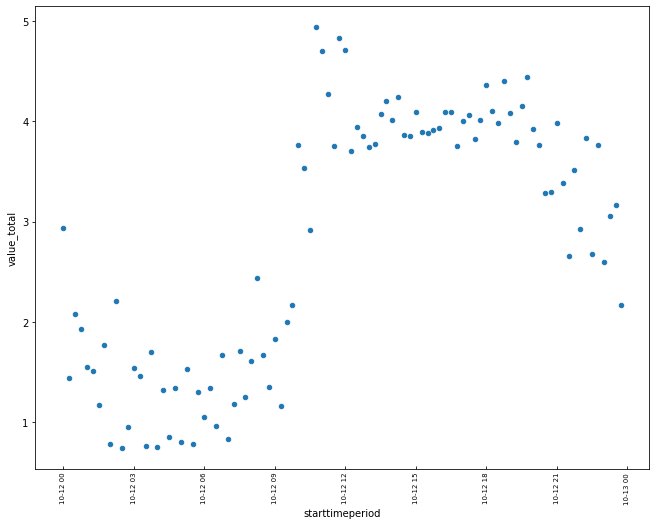

In [35]:
fig_num=0
fig, ax = plt.subplots(1, 1, num=fig_num, figsize=[11, 8.5])
df_tot.plot(ax=ax, x='starttimeperiod', y='value_total', kind='scatter')
ax.tick_params(axis='x', labelrotation=90, labelsize=7.0, direction='in');

In [36]:
df_tot[df_tot['starttimeperiod']=='2021-10-12T00:00:00-04:00']

,serialnumber,starttimeperiod,endtimeperiod,aep_endtime_utc,timezoneoffset,value_delivered,value_received,value_total,endtimeperiodUTC_fromUTC,endtimeperiodLocal_fromUTC


In [37]:
df_tot.dtypes

serialnumber                           object
starttimeperiod                datetime64[ns]
endtimeperiod                  datetime64[ns]
aep_endtime_utc                         int32
timezoneoffset                timedelta64[ns]
value_delivered                       float64
value_received                        float64
value_total                           float64
endtimeperiodUTC_fromUTC       datetime64[ns]
endtimeperiodLocal_fromUTC     datetime64[ns]
dtype: object